In [1]:
import os
import cv2
import random
import glob as gb
import numpy as np
import pandas as pd 
import tensorflow as tf
import pydicom as dicom
from tensorflow import keras
from keras.models import Model 
from keras import backend as K
import matplotlib.pyplot as plt
from pydicom.data import get_testdata_file
from keras.layers import Conv2D , MaxPooling2D ,concatenate ,Input ,Dropout ,Conv2DTranspose

os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
from segmentation_models import Unet,get_preprocessing
from keras.utils import plot_model
from keras.callbacks import EarlyStopping ,ReduceLROnPlateau ,ModelCheckpoint

2024-03-09 00:05:26.621634: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-09 00:05:26.720942: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-09 00:05:27.130946: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-09 00:05:28.539885: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Segmentation Models: using `tf.keras` framework.


In [2]:
train_path = "data/train/"
# setting image height and width
img_width = 256
img_height = 256
# initialize list x-train and y-train
X_train=[]
Y_train=[]

for folder in os.listdir(train_path): 
    files=gb.glob(train_path+folder+'/image/*.png')
    for file in files :
        img =cv2.imread(file,0)
        img = cv2.resize(img, (img_width, img_height)) 
        X_train.append(list(img)) 
    files=gb.glob(train_path+folder+'/mask/*.png')
    for file in files :
        img =cv2.imread(file,0)
        img = cv2.resize(img, (img_height, img_width)) 
        Y_train.append(list(img)) 

## Training data Images

In [3]:
# x_train was a list till now lets make an np array of it.
X_train=np.array(X_train)
print(X_train.shape)
print(len(X_train))
X_train=np.stack((X_train,)*3,axis=-1)


(2532, 256, 256)
2532


In [4]:
X_train.shape

(2532, 256, 256, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


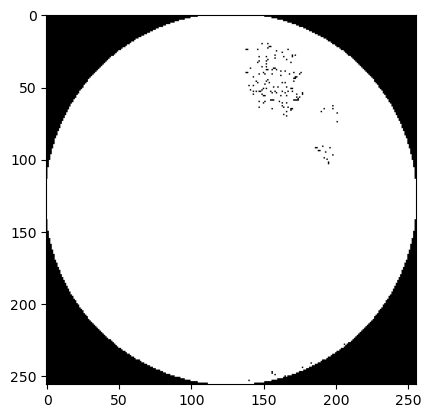

In [5]:
plt.imshow(X_train[0].astype(np.float32))

In [6]:
X_train

array([[[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        ...,

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]],


       [[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0,

In [7]:
X_train = X_train/X_train.max()

In [8]:
X_train[0]

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

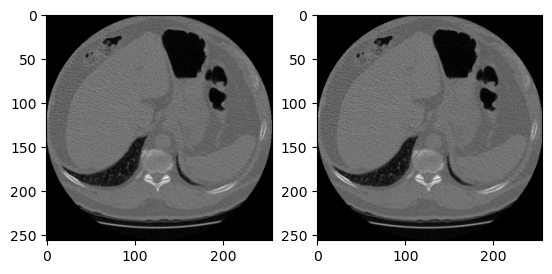

In [9]:
fig = plt.figure() 
fig.add_subplot(1,2,1)
plt.imshow(X_train[0].astype(np.float32))
fig.add_subplot(1,2,2)
plt.imshow(X_train[0].astype(np.float64))

In [10]:
X_train=X_train.astype(np.float32)

In [11]:
scans = list(np.random.randint(0,len(Y_train),16))
# [np.random.randint(0,len(Y_train),16)]

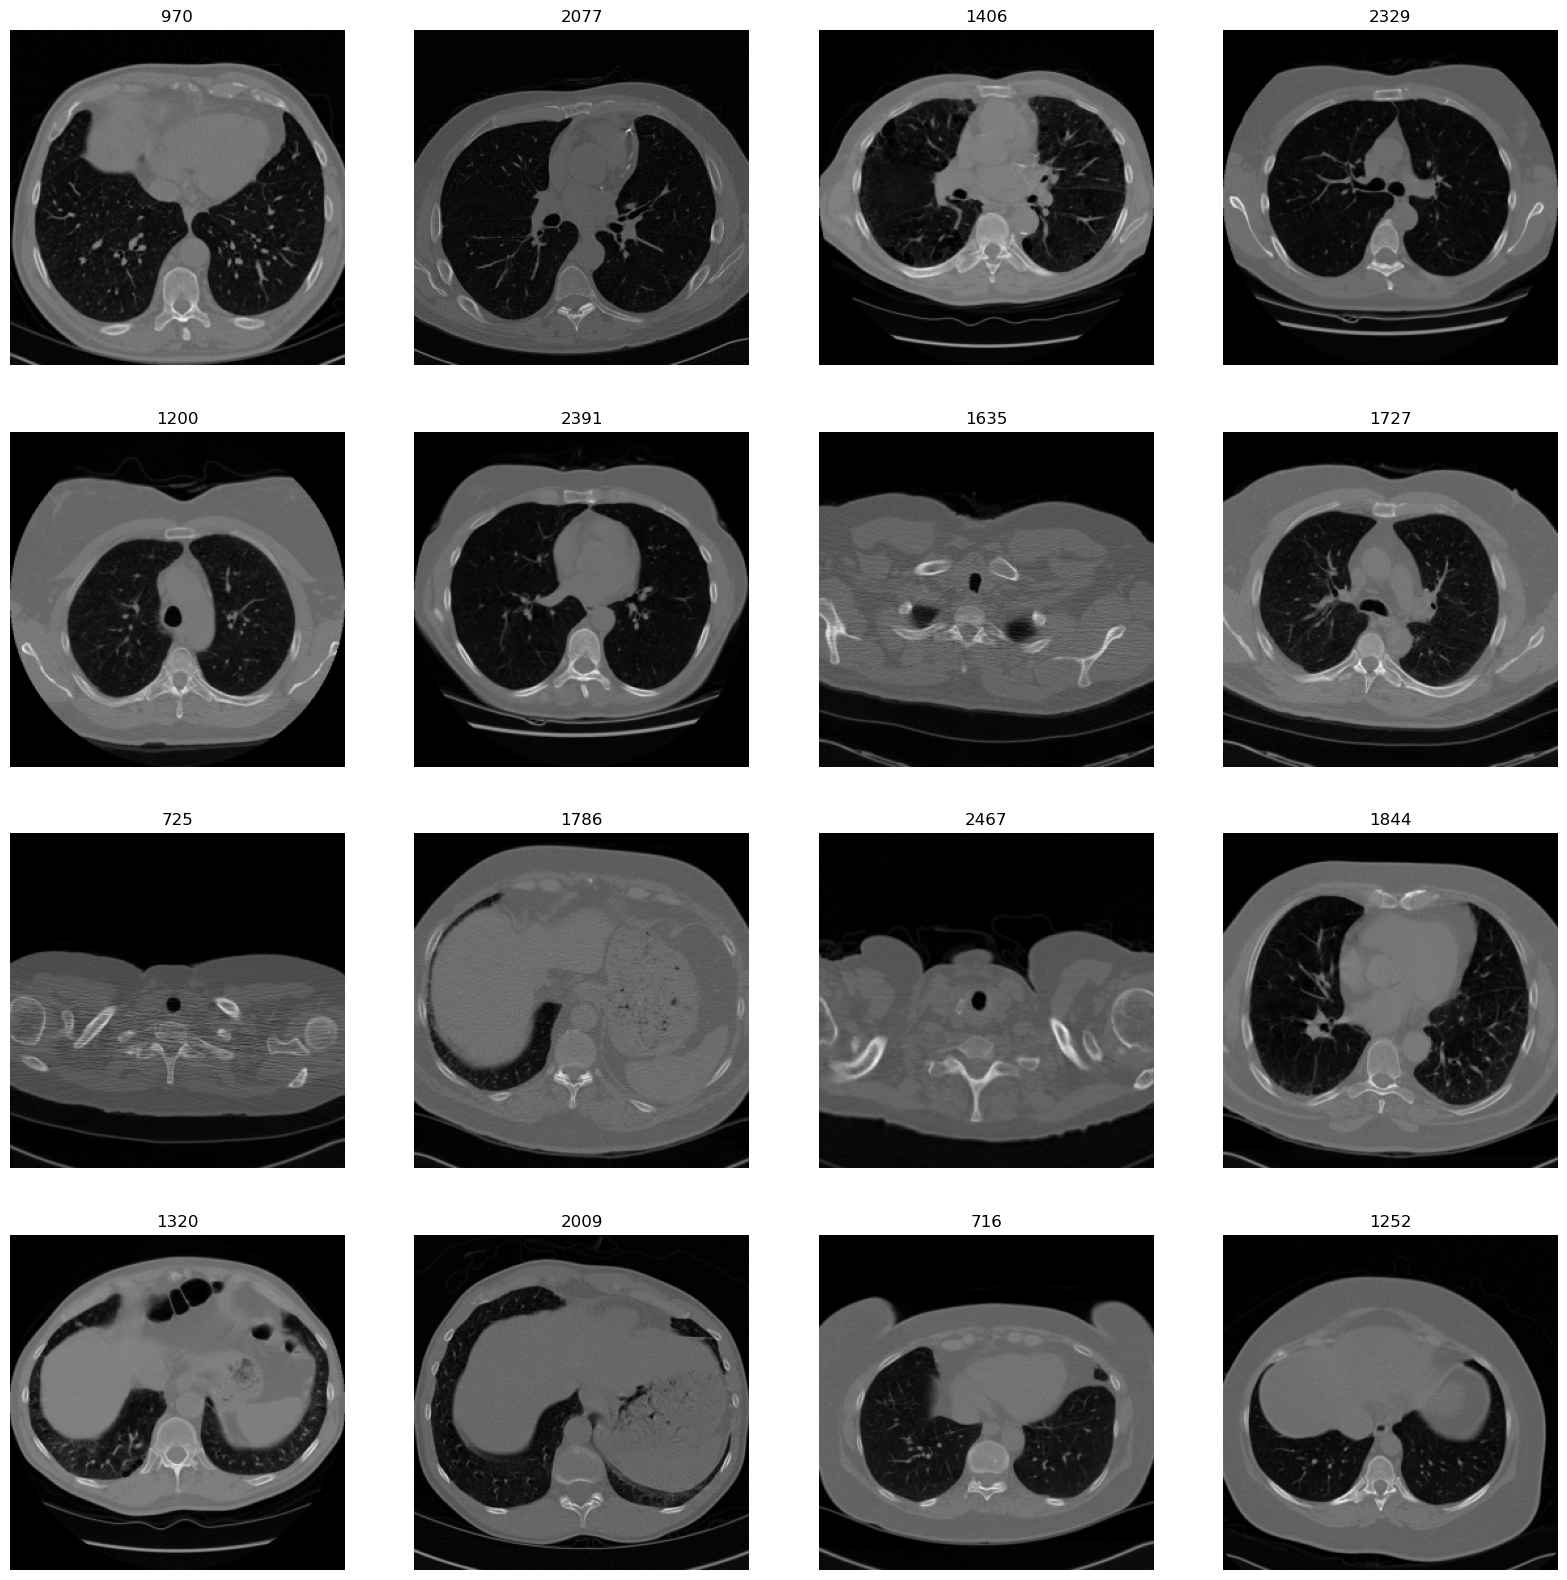

In [12]:
plt.figure(figsize=(20,20));
for n ,i in enumerate(scans):
    plt.subplot(4,4,n+1)
    plt.imshow(X_train[i],cmap='gray')
    plt.axis('off')
    plt.title(i)

## Training Data masks 

In [13]:
Y_train=np.array(Y_train,np.bool_)
Y_train.shape

(2532, 256, 256)

In [14]:
Y_train[0]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [15]:
Y_train = Y_train/255

In [16]:
Y_train=np.expand_dims(Y_train,axis=-1)

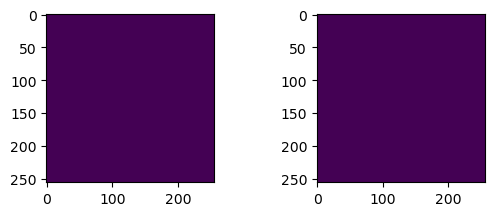

In [17]:
fig = plt.figure() 
fig.add_subplot(2,2,1)
plt.imshow(Y_train[0].astype(np.float32))
fig.add_subplot(2,2,2)
plt.imshow(Y_train[0].astype(np.float64))

In [18]:
Y_train=Y_train.astype(np.float32)

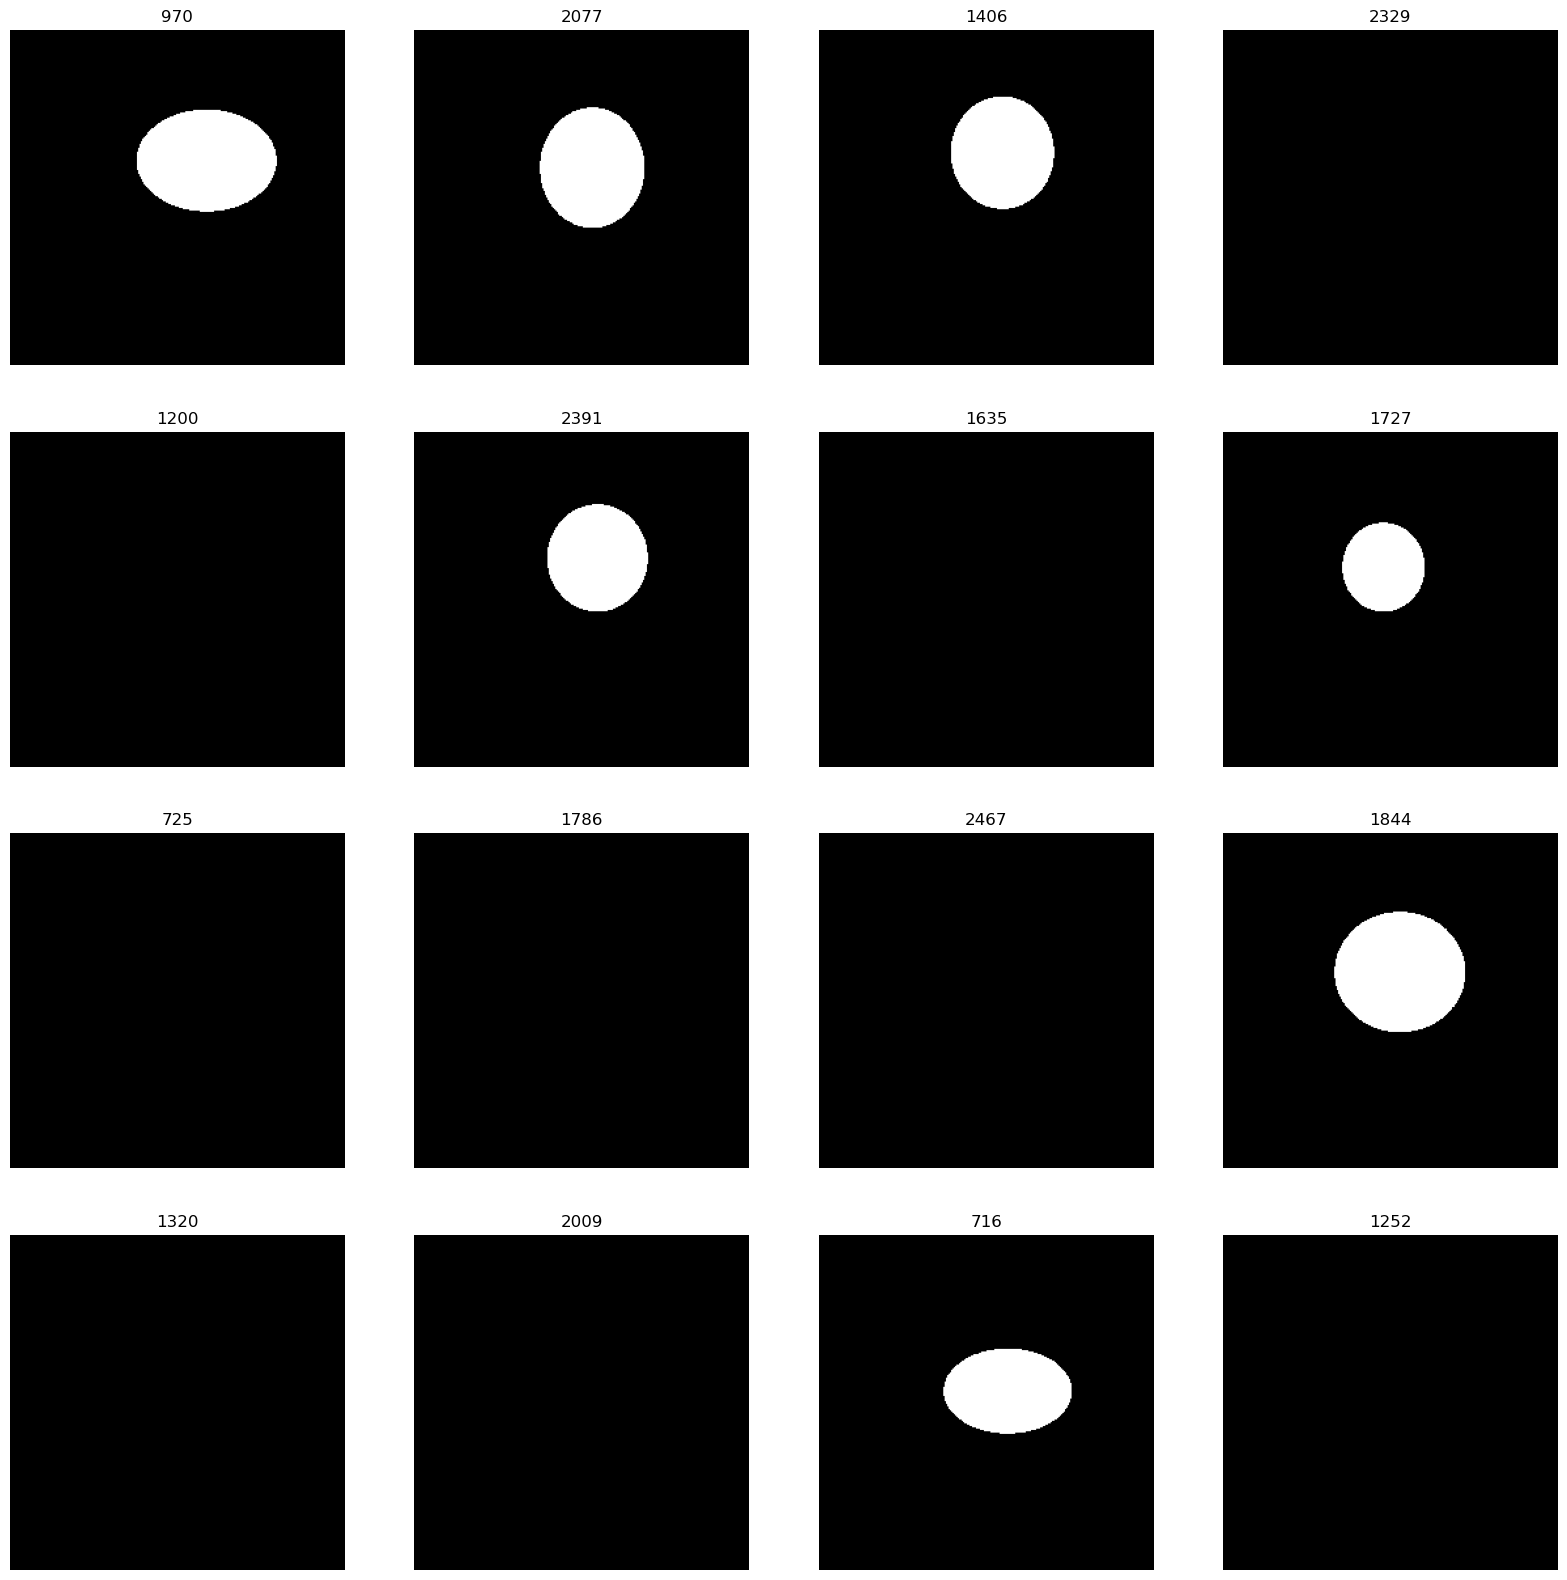

In [19]:
plt.figure(figsize=(20,20))
for n ,i in enumerate(scans) :
    plt.subplot(4,4,n+1)
    plt.imshow(Y_train[i],cmap='gray')
    plt.axis('off')
    plt.title(i)

## Testing Data images

In [20]:
TEST_PATH ='data/test/'
X_test=[]
for folder in os.listdir(TEST_PATH):
    files=gb.glob(TEST_PATH+folder+'/'+str(os.listdir(TEST_PATH+'/'+folder)[0])+'/*.dcm')
    for file in files :
        ds = dicom.dcmread(file)
        img = ds.pixel_array
        img = cv2.resize(img, (img_height, img_width)) 
        X_test.append(list(img))

In [21]:
X_test=np.array(X_test)

In [22]:
X_test=np.stack((X_test,)*3,axis=-1)
X_test.shape

(832, 256, 256, 3)

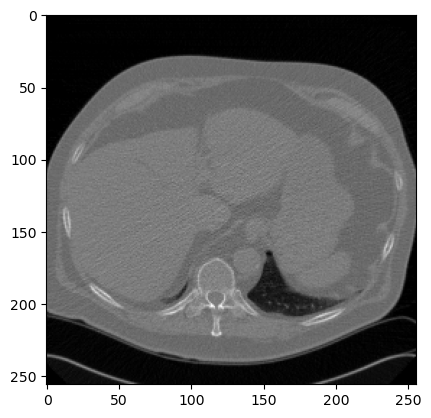

In [23]:
plt.imshow((X_test[259]/X_test[259].max()).astype(np.float32))
# plt.imshow(X_train[0].astype(np.float32))

In [24]:
X_test = X_test/X_test.max()

In [25]:
X_test[0]

array([[[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.01882986, 0.01882986, 0.01882986],
        [0.01479489, 0.01479489, 0.01479489],
        [0.01244116, 0.01244116, 0.01244116]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.0205111 , 0.0205111 , 0.0205111 ],
        [0.00941493, 0.00941493, 0.00941493],
        [0.01008742, 0.01008742, 0.01008742]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.00975118, 0.00975118, 0.00975118],
        [0.0127774 , 0.0127774 , 0.0127774 ],
        [0.00605245, 0.00605245, 0.00605245]],

       ...,

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0

In [26]:
X_test=X_test.astype(np.float32)

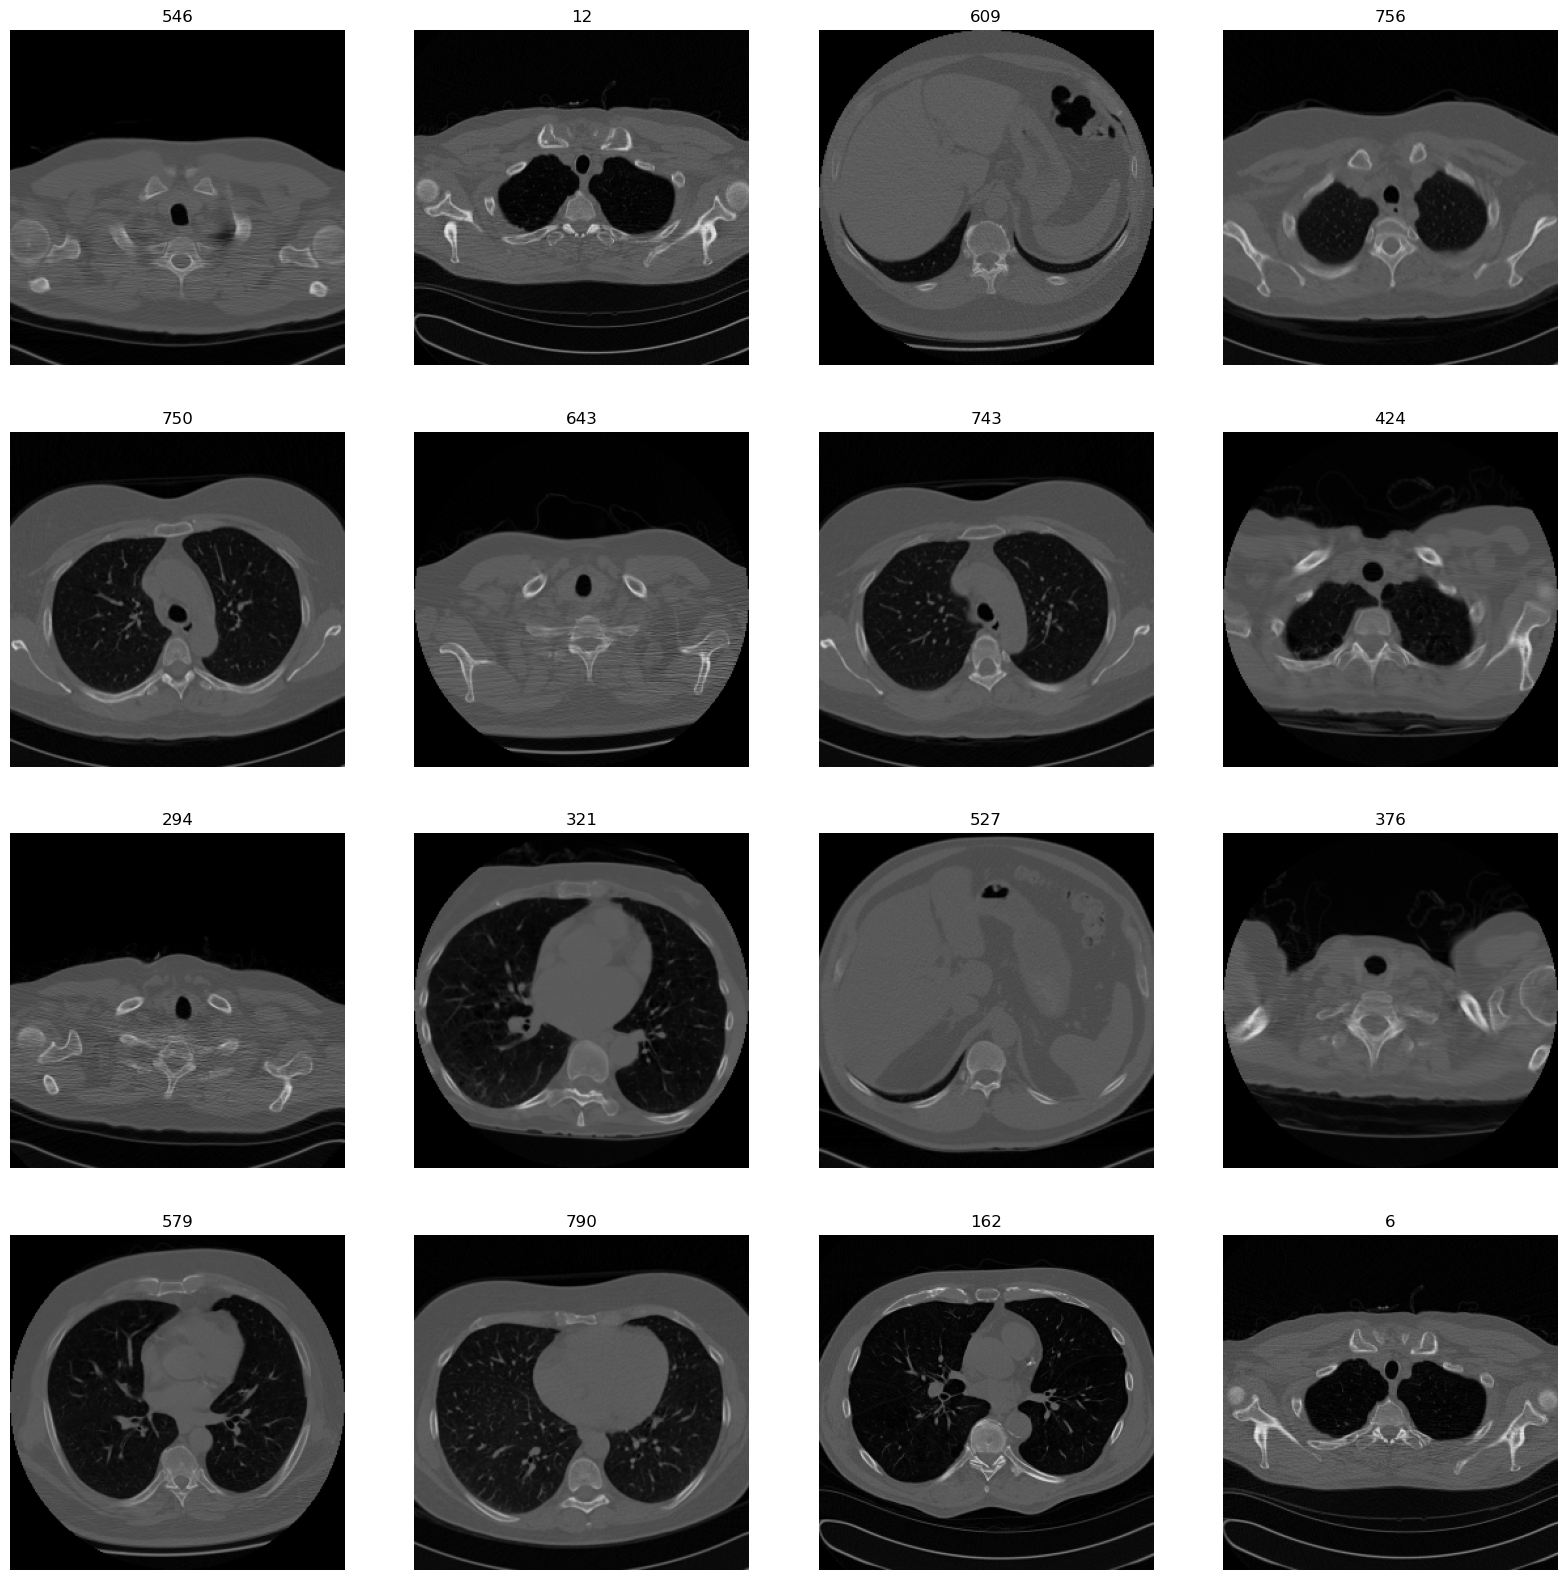

In [27]:
plt.figure(figsize=(20,20))
for n ,i in enumerate(list(np.random.randint(0,len(X_test),16))) :
    plt.subplot(4,4,n+1)
    # Image = np.clip(Image, 0, 1)
    plt.imshow(np.clip(X_test[i],0,1))
    plt.axis('off')
    plt.title(i)


# Model Prepration
link to the reffered kaggle notebook: 
- https://www.kaggle.com/code/vuppalaadithyasairam/unet-for-heart-segmentation
- https://www.kaggle.com/code/hossamfakher/ct-heart-segmentation

In [28]:
BACKBONE = 'resnet34'
preprocess_input = get_preprocessing(BACKBONE)

# X_train_prep = preprocess_input(X_train)
# X_test_prep = preprocess_input(X_test)

In [29]:
dice_loss = sm.losses.DiceLoss()

activation = "sigmoid" #as we have binary classes
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

metrics = ['accuracy',sm.metrics.IOUScore(),sm.metrics.FScore(threshold=0.5)]

2024-03-09 00:06:04.187985: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-09 00:06:04.205493: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [30]:
model = Unet(BACKBONE, encoder_weights='imagenet',activation=activation) 

In [31]:
model.compile(optimizer=optimizer,loss=dice_loss,metrics = metrics)

In [32]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('model_archives/model_{epoch:02d}.keras',verbose=1,save_best_only=True),
    tf.keras.callbacks.EarlyStopping(patience = 3, monitor="val_loss",restore_best_weights=True),
    tf.keras.callbacks.TensorBoard(log_dir='logs')
]

In [33]:
history=model.fit(X_train,Y_train,
                  validation_split=0.1,
                  batch_size=8, 
                  callbacks=callbacks,
                  epochs=20,
                #   steps_per_epoch=len(X_train)//32, 
                  verbose=1)

2024-03-09 00:06:11.282172: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1791492096 exceeds 10% of free system memory.
2024-03-09 00:06:18.150139: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 597164032 exceeds 10% of free system memory.


Epoch 1/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9078 - f1-score: 0.0038 - iou_score: 0.0014 - loss: 0.9973

2024-03-09 00:20:06.619736: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 199753728 exceeds 10% of free system memory.



Epoch 1: val_loss improved from inf to 0.99996, saving model to model_archives/model_01.keras
285/285 ━━━━━━━━━━━━━━━━━━━━ 845s 3s/step - accuracy: 0.9080 - f1-score: 0.0038 - iou_score: 0.0014 - loss: 0.9973 - val_accuracy: 0.9685 - val_f1-score: 2.1016e-07 - val_iou_score: 2.1875e-05 - val_loss: 1.0000
Epoch 2/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9669 - f1-score: 0.0057 - iou_score: 0.0024 - loss: 0.9953
Epoch 2: val_loss did not improve from 0.99996
285/285 ━━━━━━━━━━━━━━━━━━━━ 819s 3s/step - accuracy: 0.9669 - f1-score: 0.0057 - iou_score: 0.0024 - loss: 0.9953 - val_accuracy: 0.9685 - val_f1-score: 2.1016e-07 - val_iou_score: 8.6114e-06 - val_loss: 1.0000
Epoch 3/20
162/285 ━━━━━━━━━━━━━━━━━━━━ 5:48 3s/step - accuracy: 0.9681 - f1-score: 0.0276 - iou_score: 0.0014 - loss: 0.9973

KeyboardInterrupt: 

> !tensorboard --logdir=logs/ --host localhost --port 8088

In [ ]:
y_pred=model.predict(X_train)

In [ ]:
y_pred_p=(y_pred > 0.5).astype(np.uint8)

In [ ]:
# import random


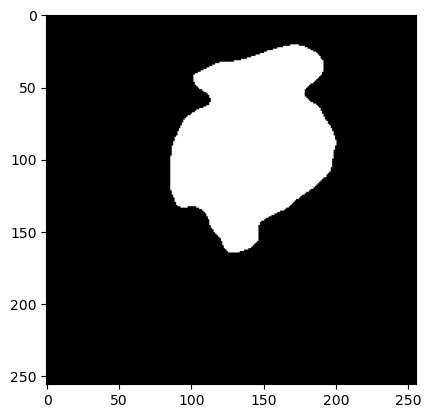

In [ ]:
t = random.randint(1,300)
plt.imshow(y_pred_p[t])

(-0.5, 255.5, 255.5, -0.5)

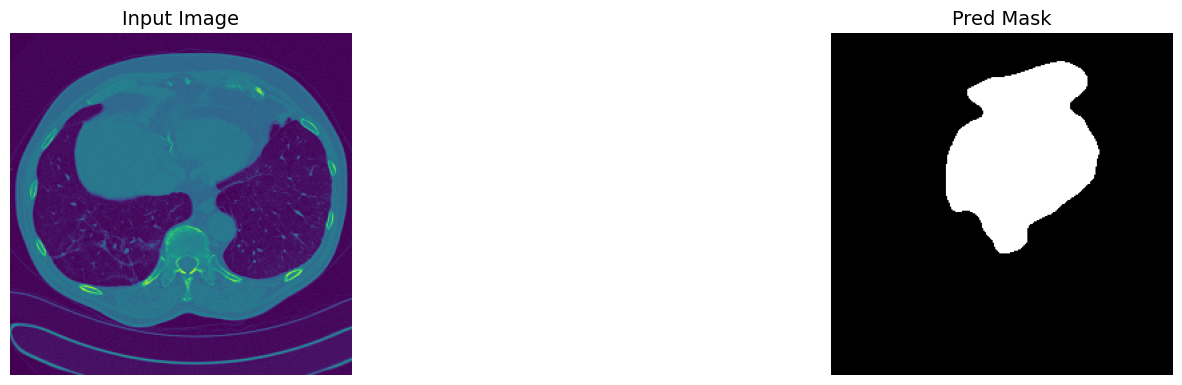

In [ ]:

plt.figure(figsize=(15,15))
plt.axis('Off')
# t = random.randint(1,300)
test_image = X_test[t, :, :, 0]
plt.subplot(1,3,1)
plt.imshow(test_image)
plt.title('Input Image', fontsize=14)
plt.axis('off')


test_mask = y_pred_p[t, :, :, 0]
plt.subplot(1,3,3)
plt.imshow(test_mask, cmap='gray')
plt.title('Pred Mask', fontsize=14)
plt.axis('off')